# TF-IDF

**ФИО:** Кобелев Даниил Дмитриевич  
**Номер группы:** 3ИСИП-423

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from datasets import load_dataset
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings("ignore")

In [3]:
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sokrat/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sokrat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sokrat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
dataset = load_dataset("ucirvine/sms_spam")
df = pd.DataFrame(dataset["train"])
df.columns = ["text", "label"]
df["label"] = df["label"].map({0: "ham", 1: "spam"})
print(f"Размер датасета: {df.shape}")
print(df.head())

Размер датасета: (5574, 2)
                                                text label
0  Go until jurong point, crazy.. Available only ...   ham
1                    Ok lar... Joking wif u oni...\n   ham
2  Free entry in 2 a wkly comp to win FA Cup fina...  spam
3  U dun say so early hor... U c already then say...   ham
4  Nah I don't think he goes to usf, he lives aro...   ham


Распределение классов:
label
ham     4827
spam     747
Name: count, dtype: int64

Процентное соотношение:
label
ham     86.598493
spam    13.401507
Name: proportion, dtype: float64


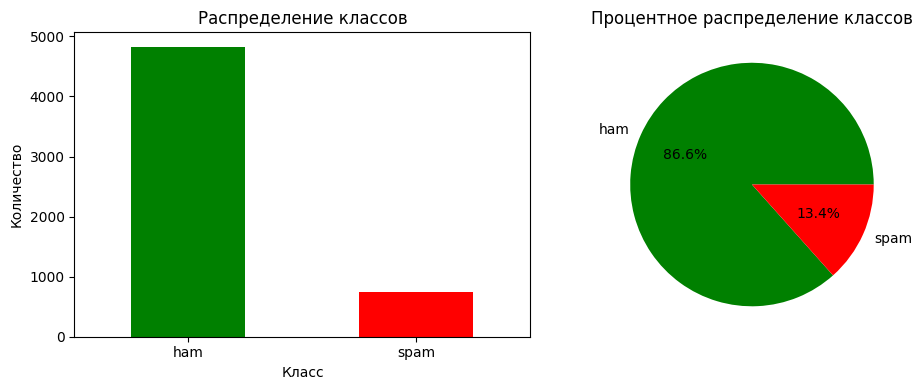

In [6]:
print("Распределение классов:")
print(df["label"].value_counts())
print(f"\nПроцентное соотношение:")
print(df["label"].value_counts(normalize=True) * 100)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df["label"].value_counts().plot(kind="bar", color=["green", "red"])
plt.title("Распределение классов")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df["label"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["green", "red"])
plt.title("Процентное распределение классов")
plt.ylabel("")

plt.tight_layout()
plt.show()

In [7]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    return " ".join(tokens)

df["cleaned_text"] = df["text"].apply(clean_text)
df["processed_text"] = df["cleaned_text"].apply(tokenize_and_lemmatize)

print("Примеры обработанного текста:")
print("Оригинал:", df["text"].iloc[0])
print("Обработанный:", df["processed_text"].iloc[0])

Примеры обработанного текста:
Оригинал: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Обработанный: jurong point crazy available bugis great world buffet cine got amore wat


In [8]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.95,
    stop_words="english"
)

X_tfidf = tfidf_vectorizer.fit_transform(df["processed_text"])
print(f"Размер TF-IDF матрицы: {X_tfidf.shape}")

feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Первые 20 признаков: {feature_names[:20]}")

Размер TF-IDF матрицы: (5574, 1000)
Первые 20 признаков: ['abiola' 'able' 'abt' 'accept' 'access' 'account' 'account statement'
 'actually' 'add' 'address' 'admirer' 'admirer looking' 'aft' 'afternoon'
 'age' 'ago' 'aight' 'aint' 'alright' 'amp']


In [9]:
X = X_tfidf
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (4459, 1000)
Размер тестовой выборки: (1115, 1000)


In [10]:
naive_bayes = MultinomialNB(alpha=1.0)
naive_bayes.fit(X_train, y_train)

y_pred = naive_bayes.predict(X_test)
print("Модель обучена успешно!")

Модель обучена успешно!


Точность (Accuracy): 0.9686
Точность (Precision): 0.9524
Полнота (Recall): 0.8054
F1-score: 0.8727

Матрица ошибок:
[[960   6]
 [ 29 120]]


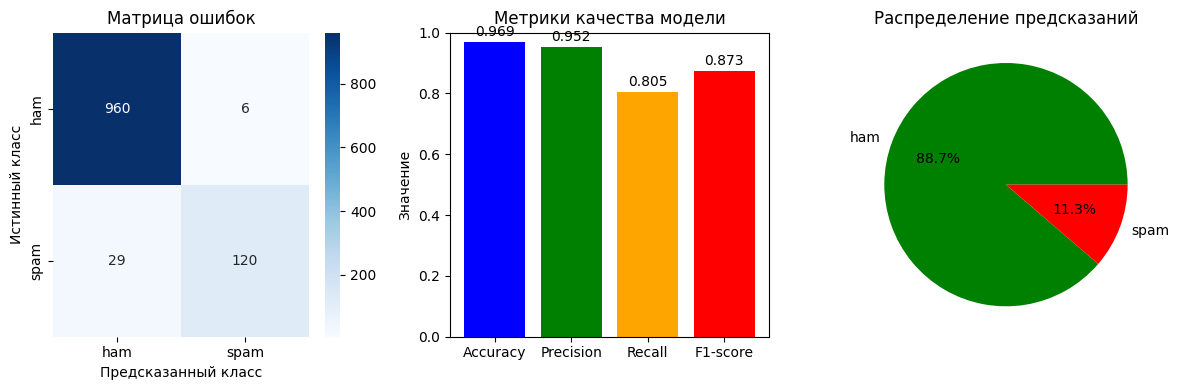


Подробный отчет о классификации:
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       966
        spam       0.95      0.81      0.87       149

    accuracy                           0.97      1115
   macro avg       0.96      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [11]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label="spam")
recall = recall_score(y_test, y_pred, pos_label="spam")
f1 = f1_score(y_test, y_pred, pos_label="spam")

print(f"Точность (Accuracy): {accuracy:.4f}")
print(f"Точность (Precision): {precision:.4f}")
print(f"Полнота (Recall): {recall:.4f}")
print(f"F1-score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print(f"\nМатрица ошибок:")
print(cm)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["ham", "spam"], yticklabels=["ham", "spam"])
plt.title("Матрица ошибок")
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")

plt.subplot(1, 3, 2)
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [accuracy, precision, recall, f1]
bars = plt.bar(metrics, values, color=["blue", "green", "orange", "red"])
plt.title("Метрики качества модели")
plt.ylabel("Значение")
plt.ylim(0, 1)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f"{value:.3f}", ha="center", va="bottom")

plt.subplot(1, 3, 3)
pred_counts = pd.Series(y_pred).value_counts()
plt.pie(pred_counts.values, labels=pred_counts.index, autopct="%1.1f%%", 
        colors=["green", "red"])
plt.title("Распределение предсказаний")

plt.tight_layout()
plt.show()

print(f"\nПодробный отчет о классификации:")
print(classification_report(y_test, y_pred))